In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

In [2]:
pip install tensorflow_datasets

     ---------------------------------------- 4.7/4.7 MB 306.9 kB/s eta 0:00:00

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 52.3/52.3 kB 207.1 kB/s eta 0:00:00
     ------------------------------------ 110.5/110.5 kB 320.4 kB/s eta 0:00:00
     ------------------------------------ 140.1/140.1 kB 438.6 kB/s eta 0:00:00
     ------------------------------------ 211.7/211.7 kB 348.5 kB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=729d3624879bc0d1b9a7f4886602da60aa9e91c8829047111170e8ee8224f752
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\6a\fe\dc\a7b3e03dfd0afb3a19691905bbafac1fbaebb704a02a4daeb2
Successfully built promise


In [2]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load("tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

In [3]:
## check existing image size
train_ds[0].shape

TensorShape([442, 1024, 3])

In [4]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

In [5]:
train_labels

<tf.Tensor: shape=(2569,), dtype=int64, numpy=array([2, 3, 3, ..., 0, 2, 0], dtype=int64)>

In [6]:
## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [7]:
train_labels[0]

array([0., 0., 1., 0., 0.], dtype=float32)

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [9]:
train_ds[0].shape

TensorShape([150, 150, 3])

In [14]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)

58889256/58889256 [==============================] - 189s 3us/step


In [15]:
## will not train base mode
# Freeze Parameters in model's lower convolutional layers
base_model.trainable = False 

In [16]:
## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [17]:
## model details
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [18]:
#add our layers on top of this model
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [20]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [21]:
history=model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
65/65 [==============================] - 336s 5s/step - loss: 1.8410 - accuracy: 0.4696 - val_loss: 1.0555 - val_accuracy: 0.6031
Epoch 2/50
65/65 [==============================] - 327s 5s/step - loss: 0.8270 - accuracy: 0.6900 - val_loss: 1.0224 - val_accuracy: 0.6595
Epoch 3/50
65/65 [==============================] - 315s 5s/step - loss: 0.6181 - accuracy: 0.7693 - val_loss: 1.2091 - val_accuracy: 0.6265
Epoch 4/50
65/65 [==============================] - 353s 5s/step - loss: 0.4299 - accuracy: 0.8234 - val_loss: 1.0689 - val_accuracy: 0.6693
Epoch 5/50
65/65 [==============================] - 351s 5s/step - loss: 0.3541 - accuracy: 0.8594 - val_loss: 0.9551 - val_accuracy: 0.7121
Epoch 6/50
65/65 [==============================] - 395s 6s/step - loss: 0.2916 - accuracy: 0.8886 - val_loss: 1.0536 - val_accuracy: 0.6965
Epoch 7/50
65/65 [==============================] - 329s 5s/step - loss: 0.2493 - accuracy: 0.9046 - val_loss: 1.1186 - val_accuracy: 0.6829
Epoch 8/50
65

In [24]:
los,accurac=model.evaluate(test_ds,test_labels)
print("Loss: ",los,"Accuracy: ", accurac)

35/35 [==============================] - 154s 4s/step - loss: 0.1679 - accuracy: 0.9310
Loss:  0.16785208880901337 Accuracy:  0.9309718608856201


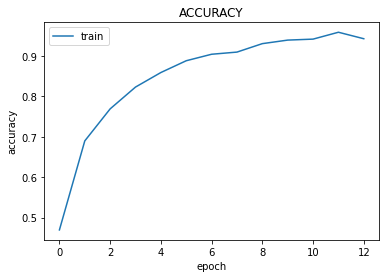

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [26]:
import numpy as np
import pandas as pd
y_pred = model.predict(test_ds)
y_classes = [np.argmax(element) for element in y_pred]
#to_categorical(y_classes, num_classes=5)
#to_categorical(test_labels, num_classes=5)
print(y_classes[:10])
print("\nTest")
print(test_labels[:10])

35/35 [==============================] - 147s 4s/step
[2, 3, 3, 3, 3, 0, 0, 0, 0, 1]

Test
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
